# Pachete necesare pentru folosirea acestui Notebook

Vom folosi [scipy](https://scipy.org/), [numpy](https://numpy.org/) și [matplotlib](https://matplotlib.org/).

In [4]:
from scipy import misc, ndimage
import scipy.io.wavfile
import numpy as np
import matplotlib.pyplot as plt
import sounddevice as sd
import cv2

# Imaginea cu care lucrăm

Vom folosi o imagine din setul de date oferit implicit de către scipy.

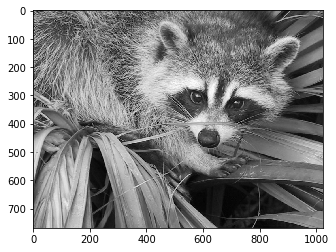

In [2]:
X = misc.face(gray=True)
plt.imshow(X, cmap=plt.cm.gray)
plt.show()

# Transformata Fourier a unei imagini

Transformata Fourier Discretă se extinde ușor la mai multe dimensiuni. Pentru un semnal bidimensional precum o imagine DFT devine:

$$
Y_{m_1,m_2} = \sum_{n_1=0}^{N_1-1}\sum_{n_2=0}^{N_2-1}x_{n_1,n_2}e^{-j2\pi(m_1 n_1/N_1 + m_2 n_2/N_2)}
$$

* unde $n_1$ și $n_2$ sunt pozițile pixelilor pe orizontală, respectiv, pe verticală
* bin-urile rezultate corespund pozițiilor pixelilor
* spectrul este în continuare simetric
* proprietățile transformatei DFT 1D sunt respectate și în cazul celei 2D

În continuare vom folosi rutina generală `fft2` ce servește mai bine activității de învățare, deși pentru semnale reale ar trebui să folosim `rfft2` ce întoarce doar informația esențială (ex. omite simetriile). De asemenea vom analiza spectrul în scală logaritmică pentru a diferenția mai bine magnitudinile bin-urilor DTF.

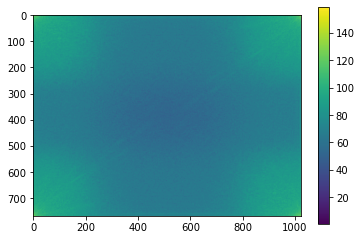

In [5]:
Y = np.fft.fft2(X)
freq_db = 20*np.log10(abs(Y))

plt.imshow(freq_db)
plt.colorbar()
plt.show()

Operațiile efectuate direct asupra imaginii se reflectă și în spectrul acesteia. Iată un exemplu al unei rotații de 45 de grade:

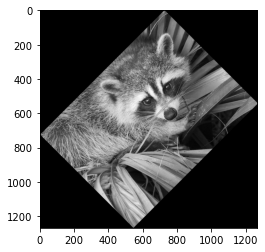

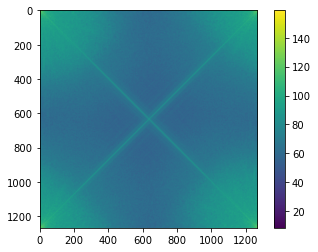

In [9]:
rotate_angle = 45
X45 = ndimage.rotate(X, rotate_angle)
plt.imshow(X45, cmap=plt.cm.gray)
plt.show()

Y45 = np.fft.fft2(X45)
plt.imshow(20*np.log10(abs(Y45)))
plt.colorbar()
plt.show()

Momentan pe axe sunt afișate numărul bin-urilor. Pentru a obține frecvențele asociate folosiți `fftfreq`:

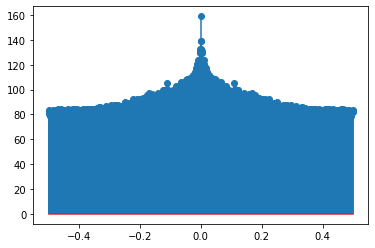

In [10]:
freq_x = np.fft.fftfreq(X.shape[1])
freq_y = np.fft.fftfreq(X.shape[0])

plt.stem(freq_x, freq_db[:][0])
plt.show()

# Atenuarea frecvențelor înalte

Pentru a anula frecvențele de peste un anumit prag `freq_cutoff` putem pur și simplu anula intrările din spectru și aplica transformata Fourier inversă:

In [3]:
freq_cutoff = 120

Y_cutoff = Y.copy()
Y_cutoff[freq_db > freq_cutoff] = 0
X_cutoff = np.fft.ifft2(Y_cutoff)
X_cutoff = np.real(X_cutoff)    # avoid rounding erros in the complex domain,
                                # in practice use irfft2
plt.imshow(X_cutoff, cmap=plt.cm.gray)
plt.show()

NameError: name 'Y' is not defined

# Zgomot

Zgomotul alb perturbă în mod egal spectrul semnalului. Este astfel egal distribuit și regăsit în toate bin-urile DFT. [Zgomotul color](https://en.wikipedia.org/wiki/Colors_of_noise) se schimbă de-a lungul frecvențelor.

Putem adăuga zgomot în limita a `pixel_noise` pixeli imaginii folosind `random.randint`:

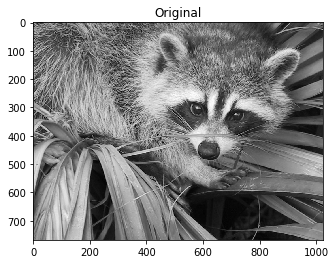

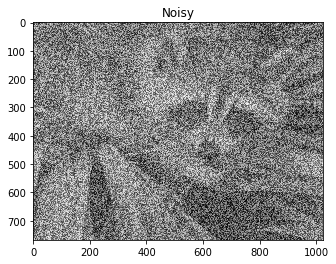

In [4]:
pixel_noise = 200

noise = np.random.randint(-pixel_noise, high=pixel_noise+1, size=X.shape)
X_noisy = X + noise
plt.imshow(X, cmap=plt.cm.gray)
plt.title('Original')
plt.show()
plt.imshow(X_noisy, cmap=plt.cm.gray)
plt.title('Noisy')
plt.show()

# Sarcini

1. [8p] Produceți imaginile și spectrul pentru funcțiile de mai jos și dați o explicație scurtă pentru fiecare rezultat.
* $x_{n_1,n_2} = \sin(2\pi n_1 + 3\pi n_2)$
* $x_{n_1,n_2} = \sin(4\pi n_1) + \cos(6\pi n_2)$
* $Y_{0,5} = Y_{0,N-5} = 1\text{, altfel }Y_{m_1,m_2} = 0,\ \forall m_1, m_2$
* $Y_{5,0} = Y_{N-5,0} = 1\text{, altfel }Y_{m_1,m_2} = 0,\ \forall m_1, m_2$
* $Y_{5,5} = Y_{N-5,N-5} = 1\text{, altfel }Y_{m_1,m_2} = 0,\ \forall m_1, m_2$

*Atenție*: $x$ reprezintă informație în domeniul timpului, $Y$ în domeniul frecvenței.

2. [4p] Comprimați imaginea cu ratonul de mai sus prin atenuarea frecvențelor înalte până la un prag SNR autoimpus.

3. [4p] Eliminați zgomotul adăugat la imaginea cu ratonul produsă mai sus. Prezentați raportul SNR înainte și după.

4. [4p] Alegeți o secvență scurtă de timp (ex. 5-10 secunde) și eliminați un instrument la alegere din semnalul audio rezultat în urma rezolvării sarcinilor de la [laboratorul 3](https://cs.unibuc.ro/~pirofti/ps/ps-lab-3.pdf).

## Exercitiul 1

In [5]:
def printImage(X):
    plt.imshow(X, cmap=plt.cm.gray)
    plt.show()

In [6]:
def printSpectre(Y):
    freq_db = 20*np.log10(1e-100 + abs(Y))
    
    plt.imshow(freq_db)
    plt.colorbar()
    plt.show()

### Subpunctul 1

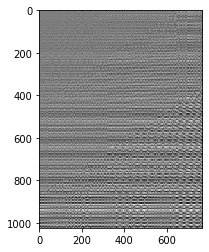

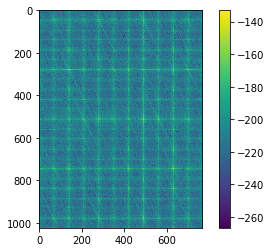

In [29]:
X = [[np.sin(2 * np.pi * n1 + 3 * np.pi * n2) for n1 in range(768)] for n2 in range(1024)]

printImage(X)
printSpectre(np.fft.fft2(X))

Observam ca functia pentru X este matematic constanta. Din cauza erorilor de aproximare pentru sin apar valori minore, care formeaza liniile verticale si orizontale din imagine. In realitate matricea este formata doar din valori de 0.
Avand in vedere aceste observatii, spectrul real este nul. Pe baza datelor obtinute, in schimb, este creata imaginea de mai sus.

### Subpunctul 2

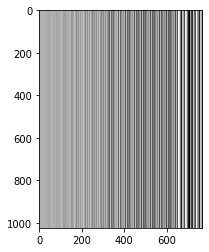

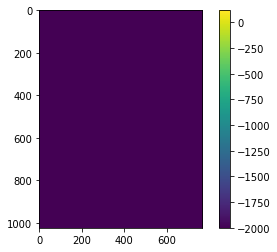

In [24]:
X = [[np.sin(4 * np.pi * n1) + np.cos(6 * np.pi * n2) for n1 in range(768)] for n2 in range(1024)]

printImage(X)
printSpectre(np.fft.fft2(X))

Observam ca functia pentru X este matematic constanta. Din cauza erorilor de aproximare pentru sin apar valori minore, care formeaza liniile verticale din imagine. In realitate matricea este formata doar din valori de 1.
Avand in vedere aceste observatii, spectrul real este un punct. Am adaugat 1e-100 in logaritm pentru a putea crea imaginea, ceea ce a dus restul valorilor de la 0 la -2000, formand imaginea de mai sus.

### Subpunctul 3

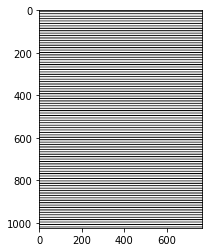

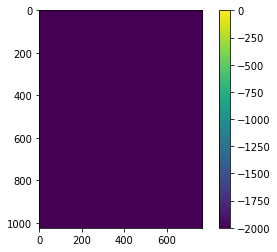

In [40]:
N = 100
Y = np.array([[1 if (m1 == 0 and (m2 == 5 or m2 == N - 5)) else 0 for m1 in range(768)] for m2 in range(1024)])

printImage(abs(np.fft.ifft2(Y)))
printSpectre(Y)

Spectrul este format din 2 puncte, iar imaginea acestuia a fost creata ca mai sus.
Cum cele 2 puncte nenule din domeniul frecventei sunt pe aceeasi linie, dar pe coloane diferite, imaginea este formata din dungi orizontale.

### Subpunctul 4

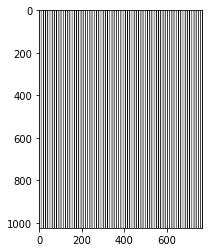

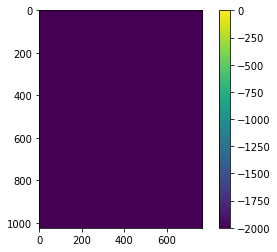

In [260]:
N = 100
Y = np.array([[1 if ((m1 == 5 or m1 == N - 5) and m2 == 0) else 0 for m1 in range(768)] for m2 in range(1024)])

printImage(abs(np.fft.ifft2(Y)))
printSpectre(Y)

Spectrul este format din 2 puncte, iar imaginea acestuia a fost creata la subpunctul 2.
Cum cele 2 puncte nenule din domeniul frecventei sunt pe aceeasi coloana, dar pe linii diferite, imaginea este formata din dungi verticale.

### Subpunctul 5

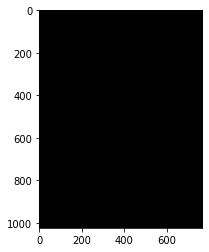

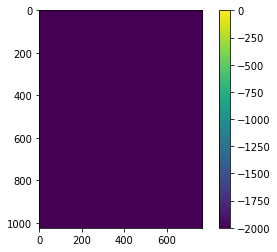

In [30]:
N = 100
Y = np.array([[1 if ((m1 == 5 and m2 == 5) or (m2 == N - 5 and m2 == N - 5)) else 0 for m1 in range(768)] for m2 in range(1024)])

printImage(abs(np.fft.ifft2(Y)))
printSpectre(Y)

Spectrul este format din 2 puncte, iar imaginea acestuia a fost creata ca la subpunctul 2.
Cum cele 2 puncte nenule din domeniul frecventei sunt pe linii si pe coloane diferite, vectorul imaginii este format doar din 1, iar imaginea este neagra.

## Exercitiul 2

In [7]:
X = misc.face(gray=True)

In [22]:
def SNR(X, X_noisy): 
    mse = np.mean((X - X_noisy) ** 2) 

    if mse == 0:
        return 1000
    
    snr = 10 * np.log10(255.0 ** 2 / mse) 
    return snr

In [23]:
def acceptSNR(X, freq_cutoff=140, step=-1):
    Y = np.fft.fft2(X)
    freq_db = 20*np.log10(abs(Y))
    X_cutoff = X
    
    while True:
        Y_cutoff = Y.copy()
        Y_cutoff[freq_db > freq_cutoff] = 0
        X_cutoff = np.fft.ifft2(Y_cutoff)
        X_cutoff = np.real(X_cutoff)
        
        if (SNR(X, X_cutoff) < 6.4):
            break
            
        printImage(X_cutoff)
        print(SNR(X, X_cutoff))
        
        freq_cutoff += step

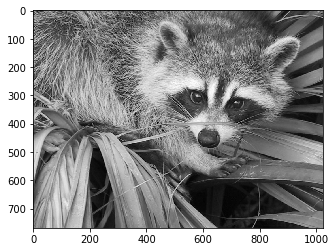

7.032396565245715


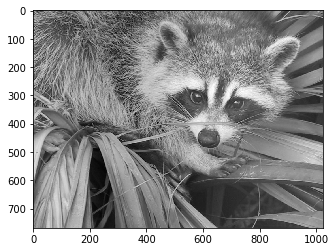

6.942172315022264


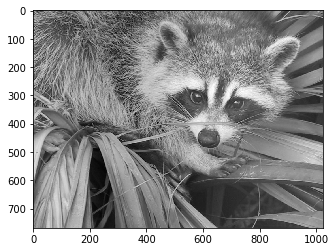

6.942172315022264


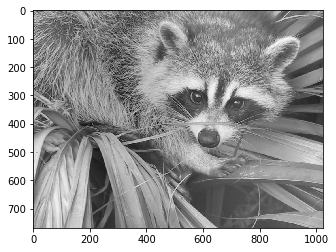

6.886655418099369


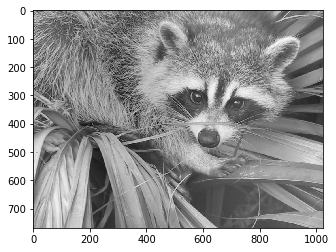

6.886655418099369


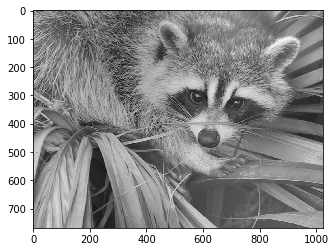

6.84977524087676


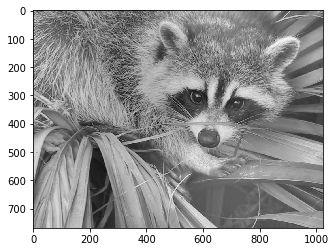

6.8233353965263


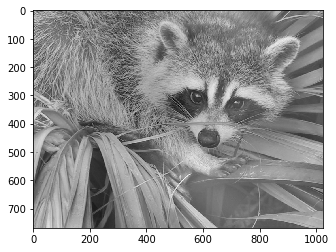

6.780986255512128


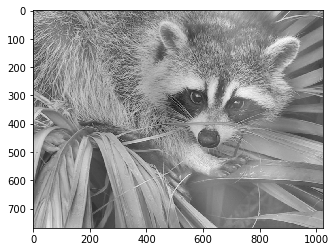

6.742838753544895


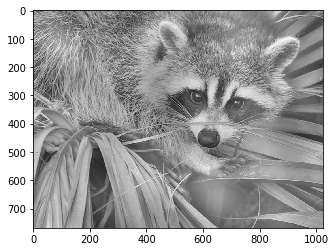

6.699537720103174


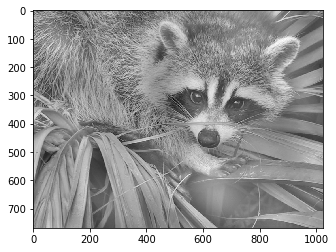

6.664385027350056


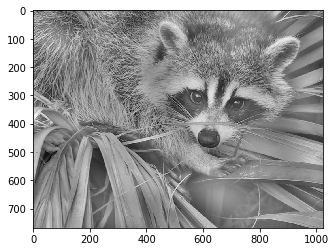

6.627626653915165


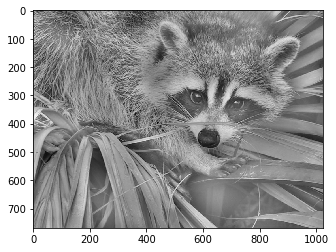

6.59847565272461


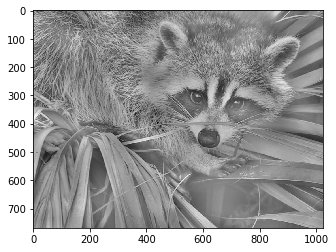

6.561365402266162


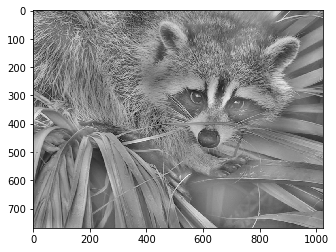

6.530891314887932


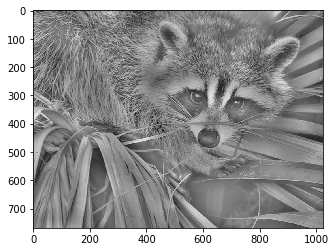

6.513324948978533


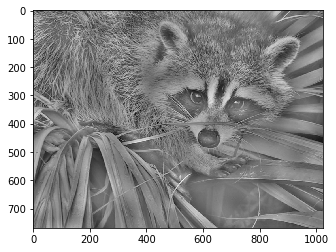

6.491461355725861


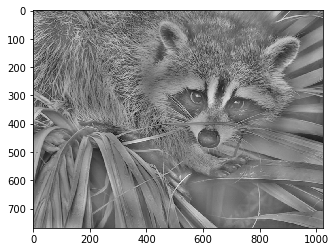

6.482948492366075


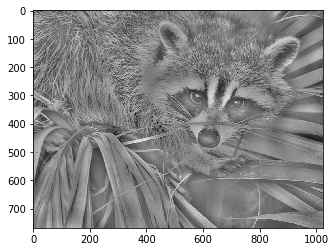

6.465423756891865


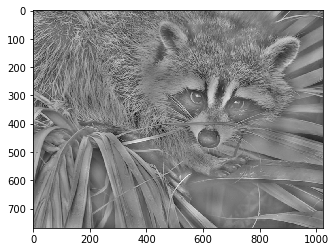

6.447676861546566


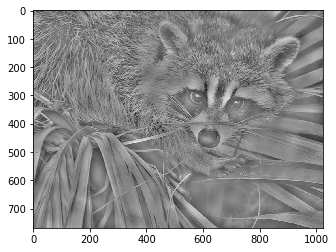

6.426647438691308


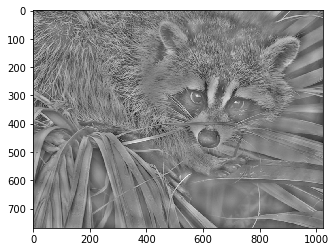

6.411969286569155


In [24]:
acceptSNR(misc.face(gray=True))

## Exercitiul 3

In [29]:
def clean(X, X_noisy):
    rows, cols = np.shape(X_noisy)

    def cond(row, col, coef=0.15):
        return (row > rows * coef and row < rows * (1 - coef)) or (col > cols * coef and col < cols * (1 - coef))

    mask = [[0 if cond(row, col) else 1 for col in range(cols)] for row in range(rows)]

    X_clean = np.abs(np.fft.ifft2(mask * np.fft.fft2(X_noisy)))
    return X_clean

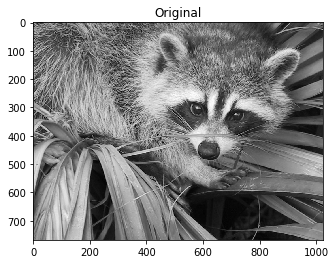

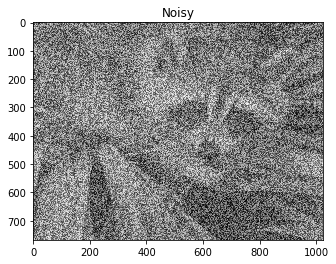

SNR: 6.859902039154036


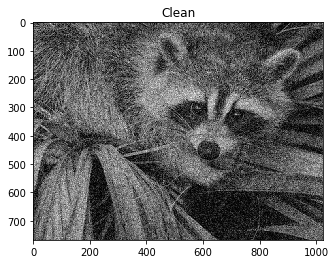

SNR: 17.206046602926037


In [30]:
pixel_noise = 200

plt.title('Original')
printImage(X)

plt.title('Noisy')
printImage(X_noisy)
print("SNR: " + str(SNR(X, X_noisy)))

X_clean = clean(X, X_noisy)
plt.title('Clean')
printImage(X_clean)
print("SNR: " + str(SNR(X, X_clean)))

## Exercitiul 4

In [2]:
def cutSignal(X, freq_cutoff):
    Y = np.fft.fft(X)
    freq_db = 20*np.log10(abs(Y))
    Y[freq_db > freq_cutoff] = 0
    X_cutoff = np.fft.ifft(Y)
    X_cutoff = np.real(X_cutoff)
    return X_cutoff

In [6]:
rate, data = scipy.io.wavfile.read("ps-lab-3.wav")
start_time = 0
end_time = 7
freq_cutoff = 111

new_data = data.copy()
new_data[rate * start_time : rate * end_time, 0] = cutSignal(data[rate * start_time : rate * end_time, 0], freq_cutoff)
new_data[rate * start_time : rate * end_time, 1] = cutSignal(data[rate * start_time : rate * end_time, 1], freq_cutoff)

wav_wave = np.array(new_data, dtype=np.int16)
sd.play(wav_wave,blocking=True)
sd.stop()